# Objective 4: Comparative Analysis of Aneurysm and Pipe Flow Simulations

This notebook loads velocity and wall shear stress (WSS) data from both aneurysm and pipe flow simulations using different methods (standard BGK and non-Newtonian BGK) to enable comparative analysis.

## Import Required Libraries

In [56]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import time
import sys
import math

# Add simulation_src to path to import utils
sys.path.append('../simulation_src')
from utils.load_csv import load_csv_data

## Define Simulation Paths

In [57]:
# Define the base directory where the simulation results are located
base_dir = Path.cwd()

# Define paths for pipe flow simulations
pipe_tdzh_nnbgk_folder = base_dir / '../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk'

# Define paths for aneurysm simulations
aneurysm_tdzh_nnbgk_folder = base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh'

# Define parameter file paths
pipe_tdzh_nnbgk_params = pipe_tdzh_nnbgk_folder / 'parameters' / 'pipe_tdzh_nnbgk_params.json'
aneurysm_tdzh_nnbgk_params = aneurysm_tdzh_nnbgk_folder / 'parameters' / 'aneurysm_tdzh_nnbgk_params.json'

# Print paths to confirm
print("Simulation paths:")
print(f"Pipe TD-ZH NNBGK: {pipe_tdzh_nnbgk_folder}")
print(f"Aneurysm TD-ZH NNBGK: {aneurysm_tdzh_nnbgk_folder}")

Simulation paths:
Pipe TD-ZH NNBGK: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk
Aneurysm TD-ZH NNBGK: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh


## Load Simulation Parameters

In [58]:
# Function to load parameters
def load_params(param_file):
    try:
        with open(param_file, 'r') as f:
            params = json.load(f)
        print(f"Successfully loaded parameters from {param_file}")
        return params
    except Exception as e:
        print(f"Error loading parameters from {param_file}: {e}")
        return None

# Load parameters for each simulation
pipe_tdzh_nnbgk_parameters = load_params(pipe_tdzh_nnbgk_params) if pipe_tdzh_nnbgk_params.exists() else None
aneurysm_tdzh_nnbgk_parameters = load_params(aneurysm_tdzh_nnbgk_params) if aneurysm_tdzh_nnbgk_params.exists() else None

# Extract key simulation parameters
def extract_key_params(params, sim_name):
    if params is None:
        print(f"No parameters available for {sim_name}")
        return {}
    
    try:
        # Extract key parameters
        key_params = {
            'dt': params['input_parameters'].get('dt', 'N/A'),
            'dx': params['input_parameters'].get('dx', 'N/A'),
            'fps': params['input_parameters'].get('fps', 'N/A'),
            'kinematic_viscosity': params['input_parameters'].get('kinematic_viscosity', 'N/A')
        }
        
        print(f"\nKey parameters for {sim_name}:")
        for key, value in key_params.items():
            print(f"  {key}: {value}")
        
        return key_params
    except Exception as e:
        print(f"Error extracting key parameters for {sim_name}: {e}")
        return {}

# Extract key parameters for each simulation
pipe_tdzh_nnbgk_key_params = extract_key_params(pipe_tdzh_nnbgk_parameters, "Pipe TD-ZH NNBGK")
aneurysm_tdzh_nnbgk_key_params = extract_key_params(aneurysm_tdzh_nnbgk_parameters, "Aneurysm TD-ZH NNBGK")

Successfully loaded parameters from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk/parameters/pipe_tdzh_nnbgk_params.json

Key parameters for Pipe TD-ZH NNBGK:
  dt: 1e-05
  dx: 2e-05
  fps: 100
  kinematic_viscosity: 3.3143939393939395e-06
No parameters available for Aneurysm TD-ZH NNBGK


## Load Velocity Data

In [59]:
# Function to load velocity data
def load_velocity_data(sim_folder, sim_name):
    data_dir = sim_folder / 'processed_data' / 'raw_fields'
    if not data_dir.exists():
        print(f"Data directory not found for {sim_name}: {data_dir}")
        return None
    
    try:
        print(f"\nLoading velocity data for {sim_name}...")
        # Load frame mapping
        frame_mapping_file = data_dir / 'frame_mapping.npz'
        if frame_mapping_file.exists():
            frame_mapping = np.load(frame_mapping_file)
            frame_numbers = frame_mapping['frame_numbers']
            frame_indices = frame_mapping['frame_indices']
            print(f"Found {len(frame_numbers)} frames, range: {min(frame_numbers)} to {max(frame_numbers)}")
        else:
            print(f"Frame mapping file not found: {frame_mapping_file}")
            return None
        
        # Load velocity components
        start_time = time.time()
        
        # Load u_x component
        u_x_file = data_dir / 'u_x.npz'
        if u_x_file.exists():
            u_x_data = np.load(u_x_file)['data']
            print(f"Loaded u_x data with shape: {u_x_data.shape}")
        else:
            print(f"u_x data file not found: {u_x_file}")
            u_x_data = None
        
        # Load u_y component
        u_y_file = data_dir / 'u_y.npz'
        if u_y_file.exists():
            u_y_data = np.load(u_y_file)['data']
            print(f"Loaded u_y data with shape: {u_y_data.shape}")
        else:
            print(f"u_y data file not found: {u_y_file}")
            u_y_data = None
        
        # Load u_magnitude
        u_magnitude_file = data_dir / 'u_magnitude.npz'
        if u_magnitude_file.exists():
            u_magnitude_data = np.load(u_magnitude_file)['data']
            print(f"Loaded u_magnitude data with shape: {u_magnitude_data.shape}")
        else:
            print(f"u_magnitude data file not found: {u_magnitude_file}")
            u_magnitude_data = None
        
        # Load grid dimensions
        dimensions_file = data_dir / 'dimensions.npz'
        if dimensions_file.exists():
            dimensions = np.load(dimensions_file)['data']
            print(f"Grid dimensions: {dimensions}")
        else:
            print(f"Dimensions file not found: {dimensions_file}")
            dimensions = None
        
        load_time = time.time() - start_time
        print(f"Data loaded in {load_time:.2f} seconds")
        
        return {
            'frame_numbers': frame_numbers,
            'frame_indices': frame_indices,
            'u_x': u_x_data,
            'u_y': u_y_data,
            'u_magnitude': u_magnitude_data,
            'dimensions': dimensions
        }
    
    except Exception as e:
        print(f"Error loading velocity data for {sim_name}: {e}")
        return None

# Load velocity data for each simulation
pipe_tdzh_nnbgk_velocity = load_velocity_data(pipe_tdzh_nnbgk_folder, "Pipe TD-ZH NNBGK")
aneurysm_tdzh_nnbgk_velocity = load_velocity_data(aneurysm_tdzh_nnbgk_folder, "Aneurysm TD-ZH NNBGK")


Loading velocity data for Pipe TD-ZH NNBGK...
Found 101 frames, range: 0 to 100000
Loaded u_x data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_magnitude data with shape: (101, 330, 751)
Grid dimensions: [752 331   1]
Data loaded in 1.74 seconds

Loading velocity data for Aneurysm TD-ZH NNBGK...
Found 101 frames, range: 0 to 100000
Loaded u_x data with shape: (101, 530, 751)
Loaded u_y data with shape: (101, 530, 751)
Loaded u_magnitude data with shape: (101, 530, 751)
Grid dimensions: [752 531   1]
Data loaded in 2.30 seconds


## Load Wall Shear Stress (WSS) Data

In [60]:
# Function to load WSS data
def load_wss_data(sim_folder, sim_name):
    data_dir = sim_folder / 'processed_data' / 'raw_fields'
    if not data_dir.exists():
        print(f"Data directory not found for {sim_name}: {data_dir}")
        return None
    
    try:
        print(f"\nLoading WSS data for {sim_name}...")
        start_time = time.time()
        
        # Load WSS x component
        wss_x_file = data_dir / 'wss_x.npz'
        if wss_x_file.exists():
            wss_x_data = np.load(wss_x_file)['data']
            print(f"Loaded wss_x data with shape: {wss_x_data.shape}")
        else:
            print(f"wss_x data file not found: {wss_x_file}")
            wss_x_data = None
        
        # Load WSS y component
        wss_y_file = data_dir / 'wss_y.npz'
        if wss_y_file.exists():
            wss_y_data = np.load(wss_y_file)['data']
            print(f"Loaded wss_y data with shape: {wss_y_data.shape}")
        else:
            print(f"wss_y data file not found: {wss_y_file}")
            wss_y_data = None
        
        # Load WSS magnitude
        wss_magnitude_file = data_dir / 'wss_magnitude.npz'
        if wss_magnitude_file.exists():
            wss_magnitude_data = np.load(wss_magnitude_file)['data']
            print(f"Loaded wss_magnitude data with shape: {wss_magnitude_data.shape}")
        else:
            print(f"wss_magnitude data file not found: {wss_magnitude_file}")
            wss_magnitude_data = None
        
        load_time = time.time() - start_time
        print(f"WSS data loaded in {load_time:.2f} seconds")
        
        return {
            'wss_x': wss_x_data,
            'wss_y': wss_y_data,
            'wss_magnitude': wss_magnitude_data
        }
    
    except Exception as e:
        print(f"Error loading WSS data for {sim_name}: {e}")
        return None

# Load WSS data for each simulation
pipe_tdzh_nnbgk_wss = load_wss_data(pipe_tdzh_nnbgk_folder, "Pipe TD-ZH NNBGK")
aneurysm_tdzh_nnbgk_wss = load_wss_data(aneurysm_tdzh_nnbgk_folder, "Aneurysm TD-ZH NNBGK")


Loading WSS data for Pipe TD-ZH NNBGK...
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_magnitude data with shape: (101, 330, 751)
WSS data loaded in 1.23 seconds

Loading WSS data for Aneurysm TD-ZH NNBGK...
Loaded wss_x data with shape: (101, 530, 751)
Loaded wss_y data with shape: (101, 530, 751)
Loaded wss_magnitude data with shape: (101, 530, 751)
WSS data loaded in 1.90 seconds


## Display Basic Information About Loaded Data

In [61]:
# Function to display basic data statistics
def display_data_stats(velocity_data, wss_data, sim_name):
    print(f"\n=== Basic statistics for {sim_name} ===\n")
    
    if velocity_data is None:
        print("No velocity data available.")
    else:
        u_magnitude = velocity_data.get('u_magnitude')
        if u_magnitude is not None and len(u_magnitude) > 0:
            first_frame = u_magnitude[0]
            non_zero_mask = first_frame > 0
            if np.any(non_zero_mask):
                print(f"Velocity statistics (first frame):")
                print(f"  Min: {first_frame[non_zero_mask].min():.6f}")
                print(f"  Max: {first_frame.max():.6f}")
                print(f"  Mean: {first_frame[non_zero_mask].mean():.6f}")
                print(f"  Std: {first_frame[non_zero_mask].std():.6f}")
            else:
                print("No non-zero velocity values found in first frame.")
    
    if wss_data is None:
        print("\nNo WSS data available.")
    else:
        wss_magnitude = wss_data.get('wss_magnitude')
        if wss_magnitude is not None and len(wss_magnitude) > 0:
            first_frame = wss_magnitude[0]
            non_zero_mask = first_frame > 0
            if np.any(non_zero_mask):
                print(f"\nWSS statistics (first frame):")
                print(f"  Min: {first_frame[non_zero_mask].min():.6f}")
                print(f"  Max: {first_frame.max():.6f}")
                print(f"  Mean: {first_frame[non_zero_mask].mean():.6f}")
                print(f"  Std: {first_frame[non_zero_mask].std():.6f}")
            else:
                print("No non-zero WSS values found in first frame.")

# Display statistics for each simulation
display_data_stats(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss, "Pipe TD-ZH NNBGK")
display_data_stats(aneurysm_tdzh_nnbgk_velocity, aneurysm_tdzh_nnbgk_wss, "Aneurysm TD-ZH NNBGK")


=== Basic statistics for Pipe TD-ZH NNBGK ===

Velocity statistics (first frame):
  Min: 0.000996
  Max: 0.161682
  Mean: 0.108296
  Std: 0.045777

WSS statistics (first frame):
  Min: 0.162501
  Max: 7.005670
  Mean: 0.235349
  Std: 0.434255

=== Basic statistics for Aneurysm TD-ZH NNBGK ===

Velocity statistics (first frame):
  Min: 0.000002
  Max: 0.160977
  Mean: 0.078606
  Std: 0.051404

WSS statistics (first frame):
  Min: 0.003322
  Max: 7.005581
  Mean: 0.171698
  Std: 0.435147


## Visualize Pipe Flow: Velocity and Wall Shear Stress

This section analyzes the pipe flow simulation, visualizing both velocity and wall shear stress fields together to understand the relationship between flow patterns and the resulting forces on the vessel walls.


Visualizing pipe flow for frame 0...


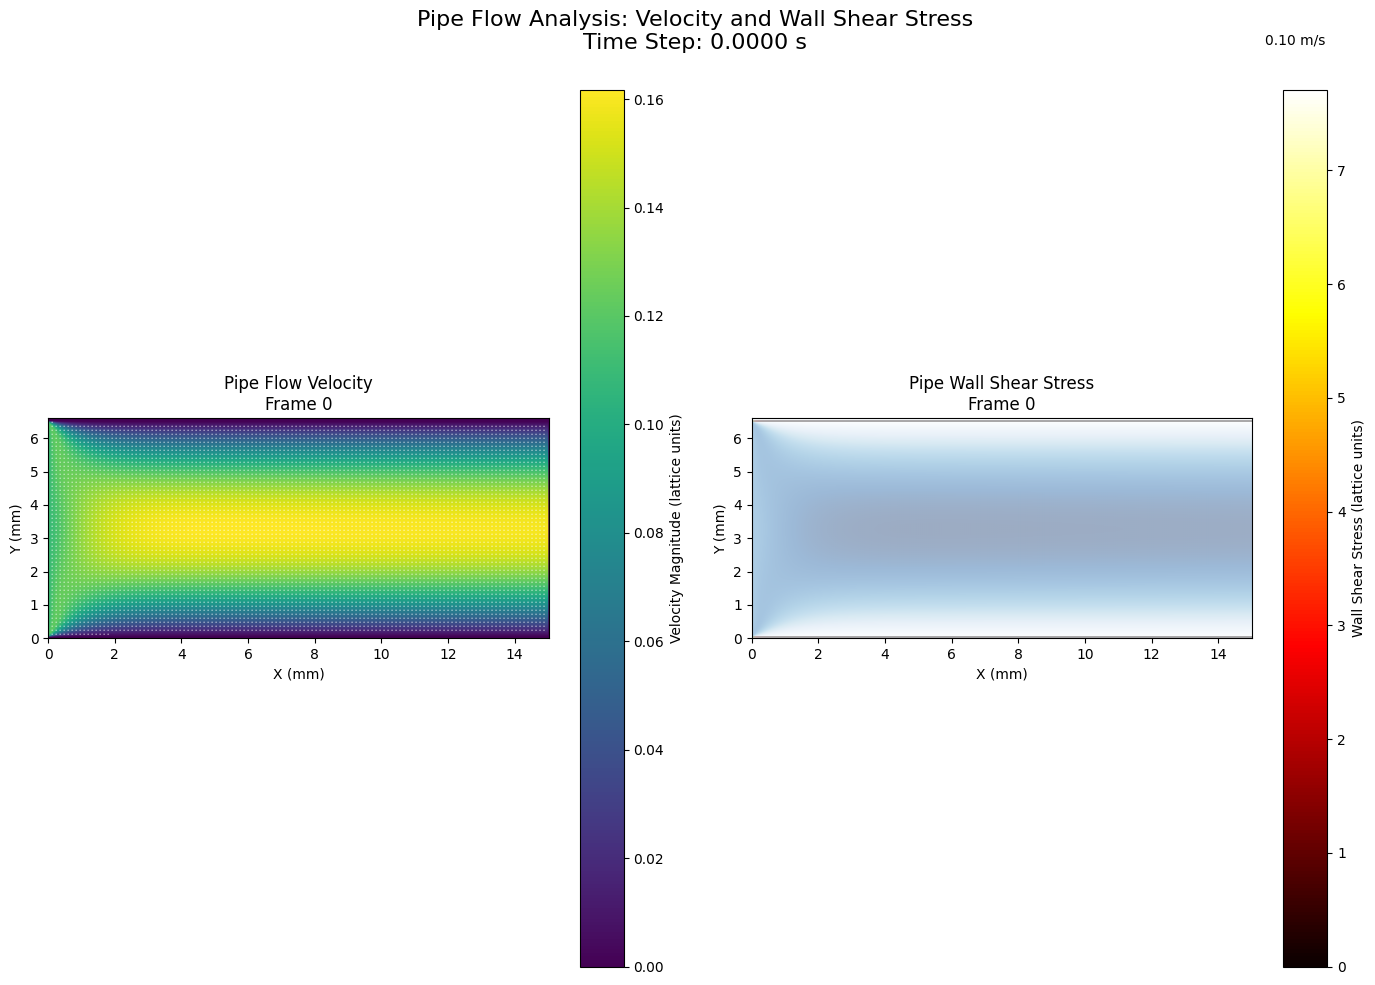


Visualizing pipe flow for frame 25...


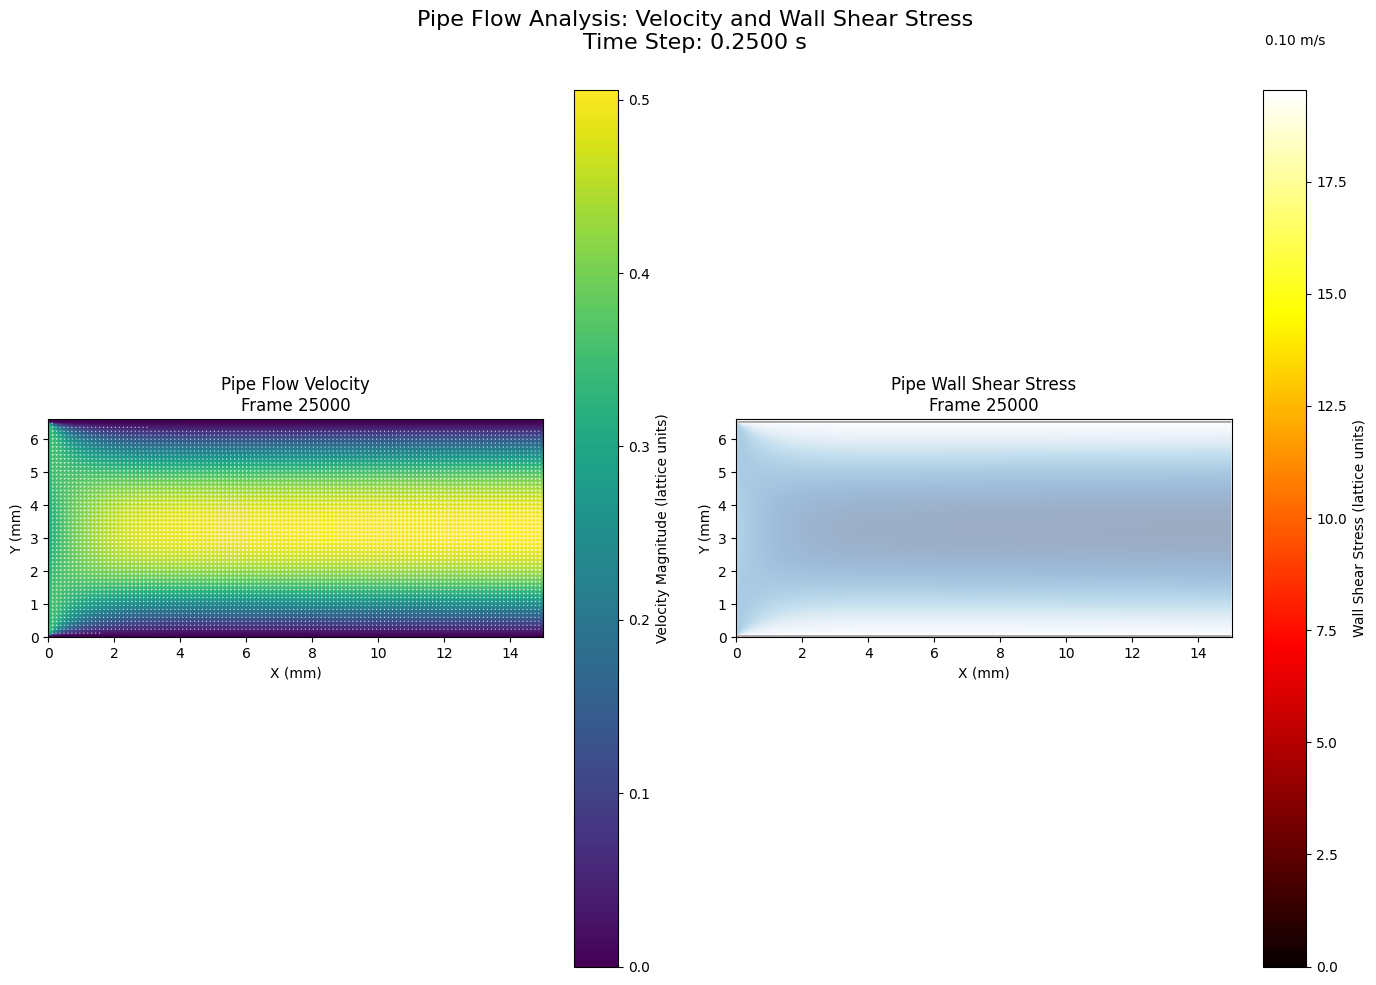


Visualizing pipe flow for frame 50...


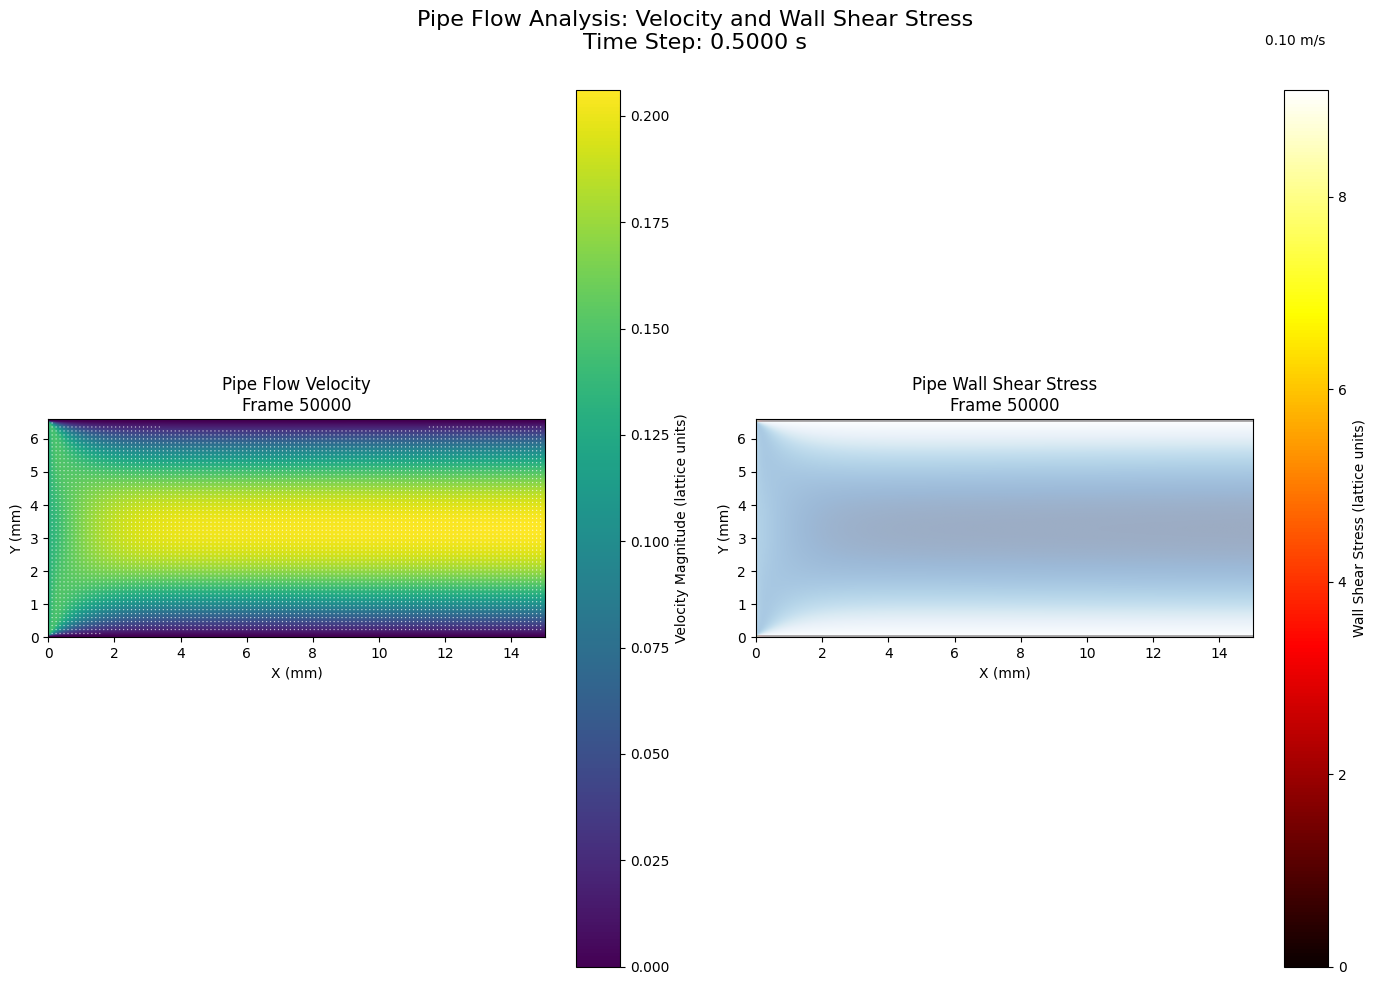


Visualizing pipe flow for frame 75...


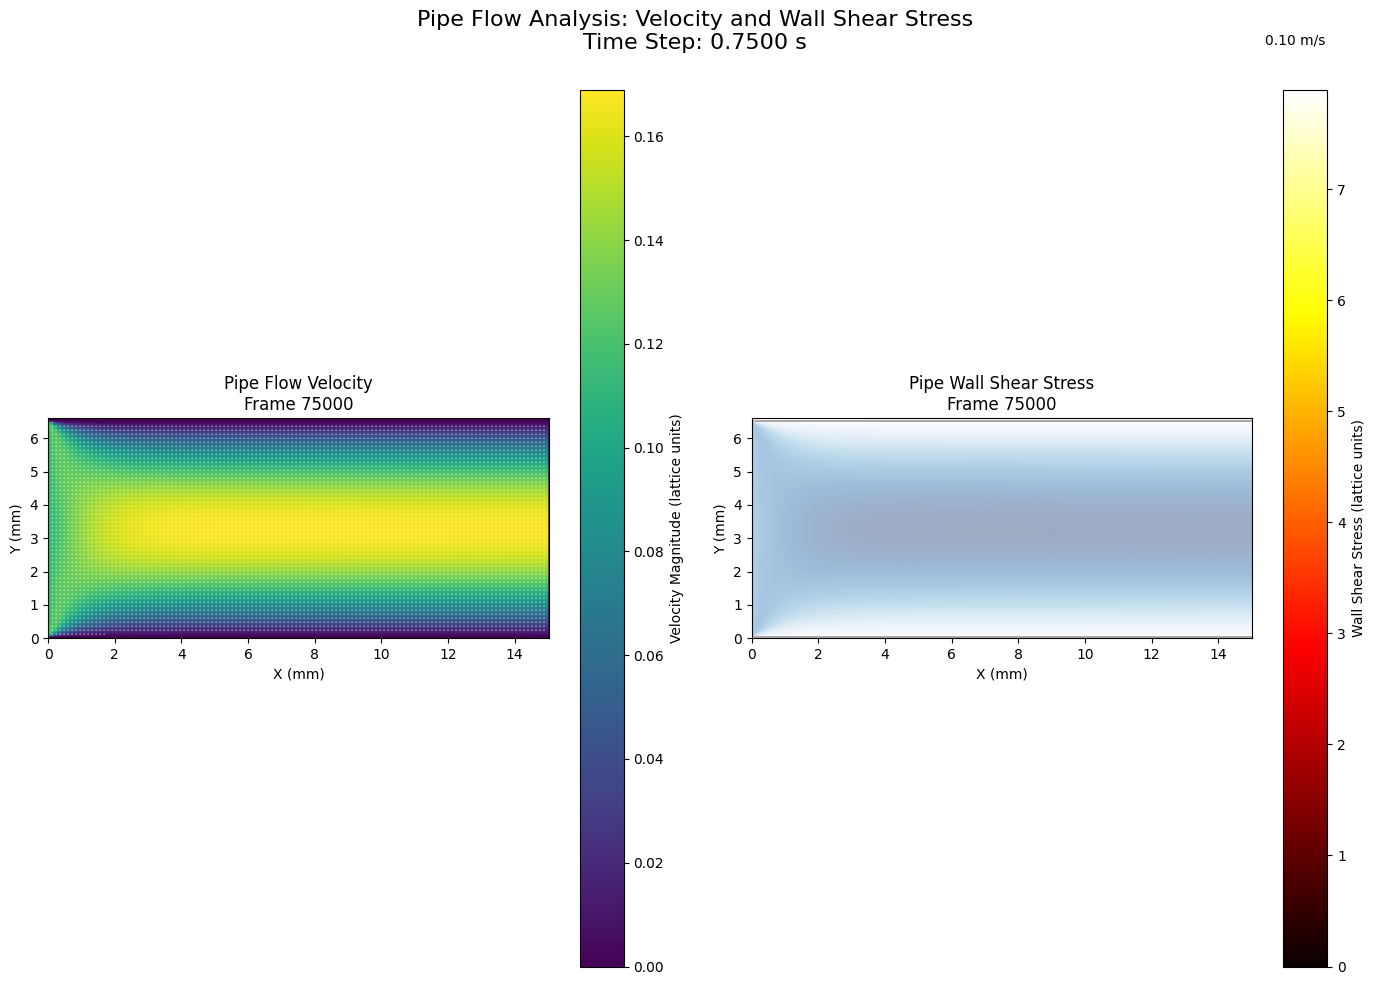


Frame with maximum velocity: 20000
Maximum velocity value: 0.546506

Visualizing pipe flow for frame with maximum velocity...


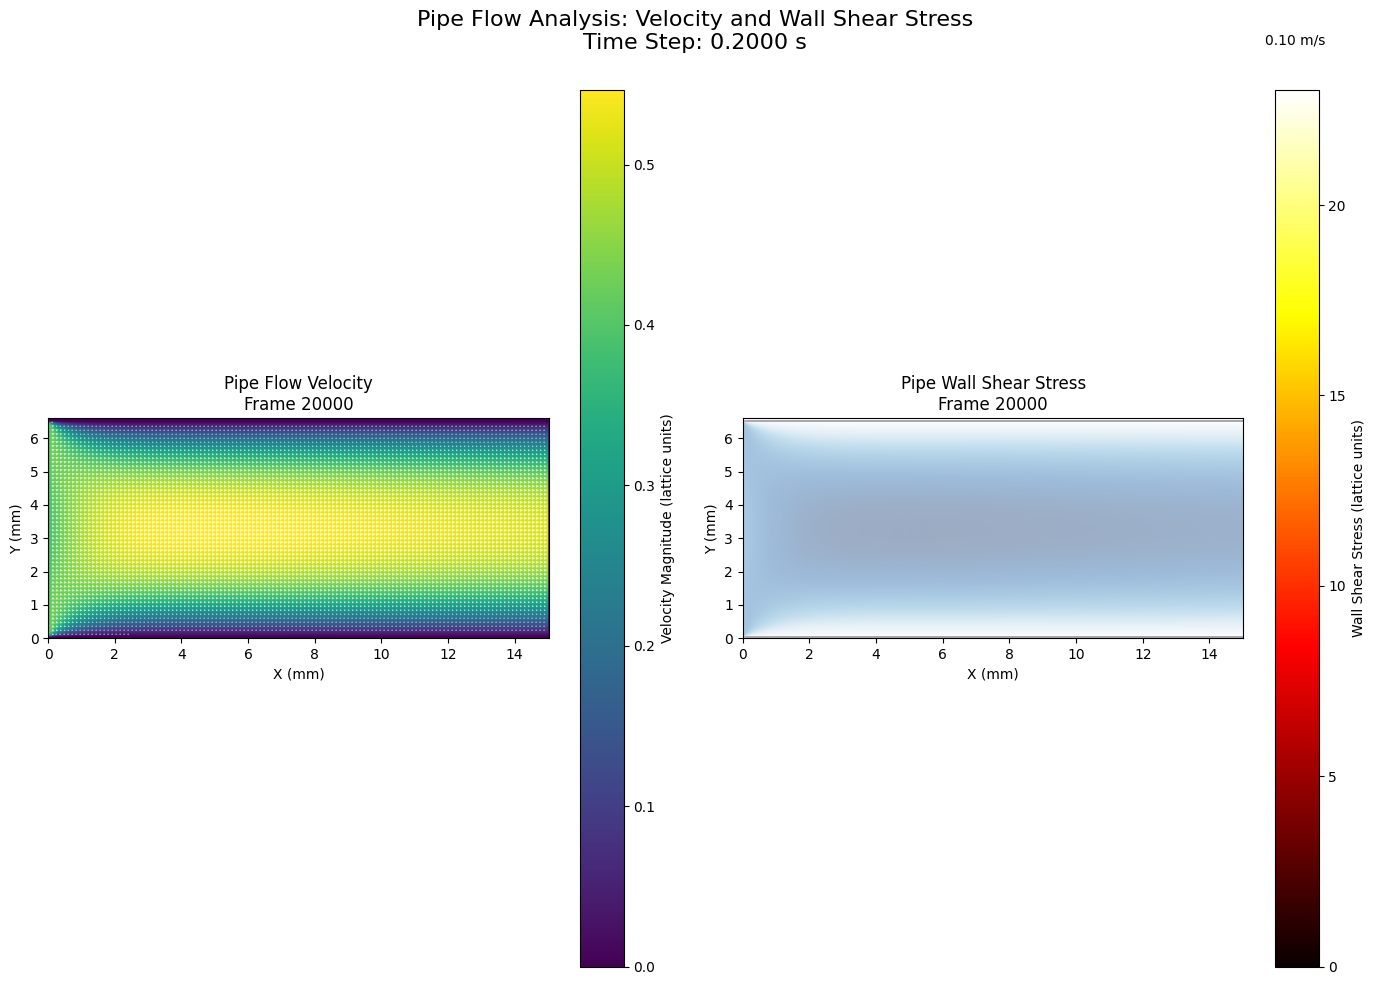

In [62]:
def visualize_pipe_flow(velocity_data, wss_data, frame_idx=50, subsample=6, velocity_scale=15, fig_size=(14, 10)):
    """Visualize pipe flow velocity and WSS for a specific frame.
    
    Args:
        velocity_data (dict): Dictionary containing velocity components and metadata
        wss_data (dict): Dictionary containing WSS components and metadata
        frame_idx (int): Index of the frame to visualize
        subsample (int): Factor to subsample the vector field for clearer visualization
        velocity_scale (float): Scaling factor for vector length
        fig_size (tuple): Size of the figure (width, height)
    """
    if velocity_data is None or wss_data is None:
        print("Missing velocity or WSS data for pipe flow")
        return
    
    # Extract frame data for velocity
    u_x = velocity_data.get('u_x')
    u_y = velocity_data.get('u_y')
    u_magnitude = velocity_data.get('u_magnitude')
    frame_numbers = velocity_data.get('frame_numbers')
    
    # Extract frame data for WSS
    wss_x = wss_data.get('wss_x')
    wss_y = wss_data.get('wss_y')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if (u_x is None or u_y is None or u_magnitude is None or frame_numbers is None or
        wss_x is None or wss_y is None or wss_magnitude is None):
        print("Missing required data components")
        return
    
    # Ensure frame_idx is valid
    if frame_idx >= len(u_x):
        frame_idx = len(u_x) // 2  # Use middle frame if specified index is invalid
        print(f"Specified frame index out of range. Using frame {frame_idx} instead.")
    
    # Get frame data
    frame_u_x = u_x[frame_idx]
    frame_u_y = u_y[frame_idx]
    frame_u_magnitude = u_magnitude[frame_idx]
    frame_num = frame_numbers[frame_idx]
    
    frame_wss_x = wss_x[frame_idx]
    frame_wss_y = wss_y[frame_idx]
    frame_wss_magnitude = wss_magnitude[frame_idx]
    
    # Create figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=fig_size)
    
    # Physical parameters
    dx = pipe_tdzh_nnbgk_key_params.get('dx', 2e-5)  # Default to 2e-5 if not available
    dt = pipe_tdzh_nnbgk_key_params.get('dt', 1e-5)  # Default to 1e-5 if not available
    
    # Grid dimensions
    ny, nx = frame_u_magnitude.shape
    
    # Convert to mm for display
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    
    # Get vessel parameters from simulation parameters if available
    if pipe_tdzh_nnbgk_parameters is not None:
        vessel_diameter_mm = pipe_tdzh_nnbgk_parameters['input_parameters'].get('vessel_diameter_mm', 6.5)
        vessel_length_mm = pipe_tdzh_nnbgk_parameters['input_parameters'].get('vessel_length_mm', 15)
        vessel_centre_lu = pipe_tdzh_nnbgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2)
    else:
        vessel_diameter_mm = 6.5  # Default values
        vessel_length_mm = 15
        vessel_centre_lu = ny // 2
        
    # Velocity visualization (left subplot)
    # -----------------------------------
    
    # Create grid for vectors
    y, x = np.mgrid[0:ny, 0:nx]
    
    # Subsample the grid for vector display
    x_sub = x[::subsample, ::subsample]
    y_sub = y[::subsample, ::subsample]
    u_x_sub = frame_u_x[::subsample, ::subsample]
    u_y_sub = frame_u_y[::subsample, ::subsample]
    
    # Plot velocity magnitude as a heatmap
    im_vel = axs[0].imshow(frame_u_magnitude, cmap='viridis', origin='lower',
                          extent=[0, nx*dx*1000, 0, ny*dx*1000])
    
    # Filter out very small vectors to reduce clutter
    vector_magnitude = np.sqrt(u_x_sub**2 + u_y_sub**2)
    threshold = np.median(vector_magnitude[vector_magnitude > 0]) * 0.1 if np.any(vector_magnitude > 0) else 0
    mask = vector_magnitude > threshold
    
    # Plot velocity vectors
    q_vel = axs[0].quiver(x_sub[mask]*dx*1000, y_sub[mask]*dx*1000, 
                         u_x_sub[mask], u_y_sub[mask],
                         color='white', scale_units='inches', scale=velocity_scale,
                         width=0.003, headwidth=4, headlength=4, alpha=0.7)
    
    # Add a key for vector scale if dt is available
    if dt:
        vel_scale_factor = dx / dt  # m/s per lattice unit
        key_value = 0.1  # m/s
        key_length = key_value / vel_scale_factor  # in lattice units
        axs[0].quiverkey(q_vel, 0.9, 0.95, key_length, f'{key_value:.2f} m/s', 
                        labelpos='E', coordinates='figure', color='white')
    
    # Add colorbar for velocity
    cbar_vel = fig.colorbar(im_vel, ax=axs[0])
    cbar_vel.set_label('Velocity Magnitude (lattice units)')
    
    # Set title and labels for velocity plot
    axs[0].set_xlabel('X (mm)')
    axs[0].set_ylabel('Y (mm)')
    axs[0].set_title(f'Pipe Flow Velocity\nFrame {frame_num}')
    
    # WSS visualization (right subplot)
    # ---------------------------------
    
    # Create a mask for the vessel walls where WSS is non-zero
    wall_mask = frame_wss_magnitude > 0
    
    # Plot velocity magnitude as background
    im_bg = axs[1].imshow(frame_u_magnitude, cmap='Blues', origin='lower',
                         extent=[0, nx*dx*1000, 0, ny*dx*1000], alpha=0.4)
    
    # For WSS, we only want to show it at the walls
    # First, create an array with NaN values
    wss_display = np.full_like(frame_wss_magnitude, np.nan)
    # Set values where WSS is non-zero
    wss_display[wall_mask] = frame_wss_magnitude[wall_mask]
    
    # Plot WSS magnitude as a heatmap
    im_wss = axs[1].imshow(wss_display, cmap='hot', origin='lower',
                          extent=[0, nx*dx*1000, 0, ny*dx*1000],
                          vmin=0, vmax=np.nanmax(wss_display)*1.1 if np.any(~np.isnan(wss_display)) else 1)
    
    # Prepare WSS vectors (only at the walls)
    wss_x_wall = np.zeros_like(frame_wss_x)
    wss_y_wall = np.zeros_like(frame_wss_y)
    
    # Only keep WSS values at the walls
    wss_x_wall[wall_mask] = frame_wss_x[wall_mask]
    wss_y_wall[wall_mask] = frame_wss_y[wall_mask]
    
    # Subsample the WSS vectors
    wss_x_sub = wss_x_wall[::subsample, ::subsample]
    wss_y_sub = wss_y_wall[::subsample, ::subsample]
    
    # Filter out zero WSS vectors
    wss_magnitude_sub = np.sqrt(wss_x_sub**2 + wss_y_sub**2)
    wss_mask = wss_magnitude_sub > 0
    
    # Plot WSS vectors at the walls if there are any non-zero vectors
    if np.any(wss_mask):
        q_wss = axs[1].quiver(x_sub[wss_mask]*dx*1000, y_sub[wss_mask]*dx*1000, 
                             wss_x_sub[wss_mask], wss_y_sub[wss_mask],
                             color='yellow', scale_units='inches', scale=velocity_scale/2,
                             width=0.003, headwidth=4, headlength=4)
        
        # Add a key for WSS vector scale
        # WSS is typically in units of Pa (N/m²)
        key_value_wss = 0.05  # arbitrary units since we're in lattice units
        axs[1].quiverkey(q_wss, 0.9, 0.89, key_value_wss, 'WSS Direction', 
                        labelpos='E', coordinates='figure', color='yellow')
    
    # Add colorbar for WSS
    cbar_wss = fig.colorbar(im_wss, ax=axs[1])
    cbar_wss.set_label('Wall Shear Stress (lattice units)')
    
    # Set title and labels for WSS plot
    axs[1].set_xlabel('X (mm)')
    axs[1].set_ylabel('Y (mm)')
    axs[1].set_title(f'Pipe Wall Shear Stress\nFrame {frame_num}')
    
    # Add overall title
    plt.suptitle(f'Pipe Flow Analysis: Velocity and Wall Shear Stress\nTime Step: {frame_num * dt:.4f} s', fontsize=16)
    
    # Tight layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig, axs

# Visualize pipe flow for multiple frames to capture the dynamics
try:
    frames_to_analyze = [0, 25, 50, 75]  # Beginning, quarter, middle, three-quarters
    
    for frame_idx in frames_to_analyze:
        print(f"\nVisualizing pipe flow for frame {frame_idx}...")
        fig, axs = visualize_pipe_flow(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss,
                                      frame_idx=frame_idx, subsample=6, velocity_scale=15)
        plt.show()
        
    # Find frame with maximum velocity and visualize it
    if pipe_tdzh_nnbgk_velocity is not None and 'u_magnitude' in pipe_tdzh_nnbgk_velocity:
        # Calculate maximum velocity for each frame
        max_velocities = np.array([frame.max() for frame in pipe_tdzh_nnbgk_velocity['u_magnitude']])
        max_velocity_frame = np.argmax(max_velocities)
        print(f"\nFrame with maximum velocity: {pipe_tdzh_nnbgk_velocity['frame_numbers'][max_velocity_frame]}")
        print(f"Maximum velocity value: {max_velocities[max_velocity_frame]:.6f}")
        
        # Visualize the frame with maximum velocity
        print("\nVisualizing pipe flow for frame with maximum velocity...")
        fig, axs = visualize_pipe_flow(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss,
                                      frame_idx=max_velocity_frame, subsample=6, velocity_scale=15)
        plt.show()
        
except Exception as e:
    print(f"Error visualizing pipe flow: {e}")
    import traceback
    traceback.print_exc()

## Analyze Wall Shear Stress Distribution in Pipe

This section analyzes the wall shear stress distribution along the pipe walls, which is critical for understanding potential regions of flow disturbance or increased risk.


Analyzing wall shear stress distribution for middle frame 50000...


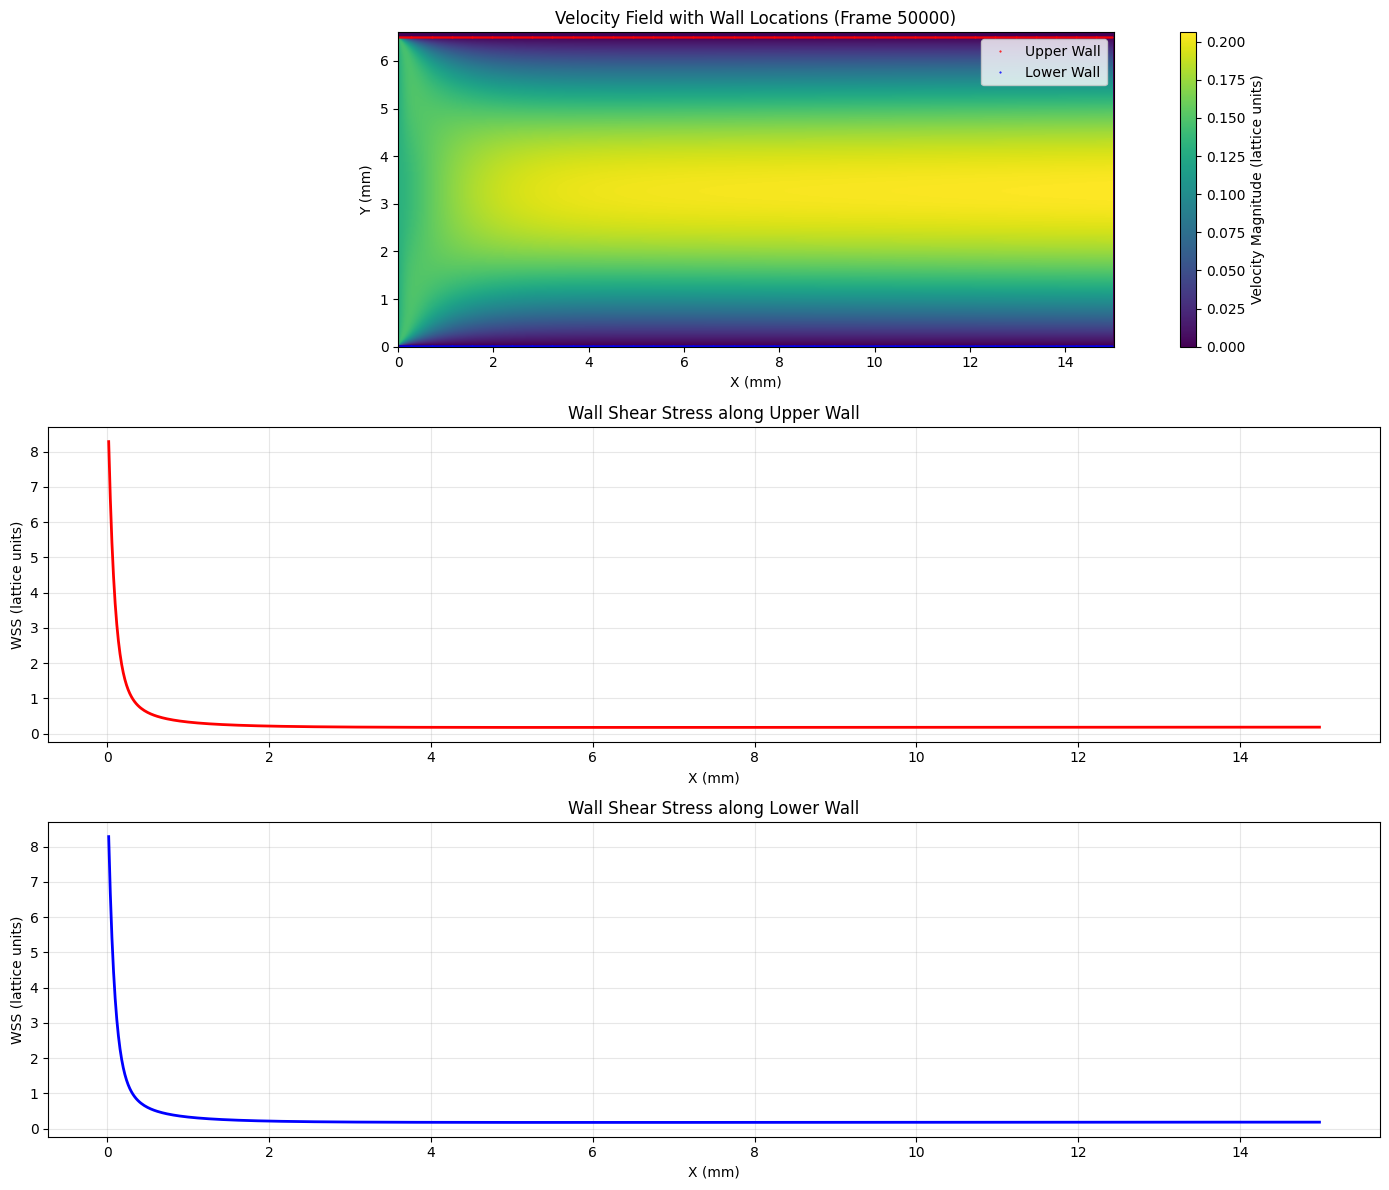


Wall Shear Stress Statistics:
Upper Wall - Mean: 0.259012, Max: 8.280953, Std: 0.512871
Lower Wall - Mean: 0.259012, Max: 8.280957, Std: 0.512871
Overall - Mean: 0.259012, Max: 8.280957

Entry Region:
  Upper Wall - Mean: 0.581380, Max: 8.280953
  Lower Wall - Mean: 0.581380, Max: 8.280957

Middle Region:
  Upper Wall - Mean: 0.175578, Max: 0.176994
  Lower Wall - Mean: 0.175578, Max: 0.176997

Exit Region:
  Upper Wall - Mean: 0.181904, Max: 0.182985
  Lower Wall - Mean: 0.181904, Max: 0.182984


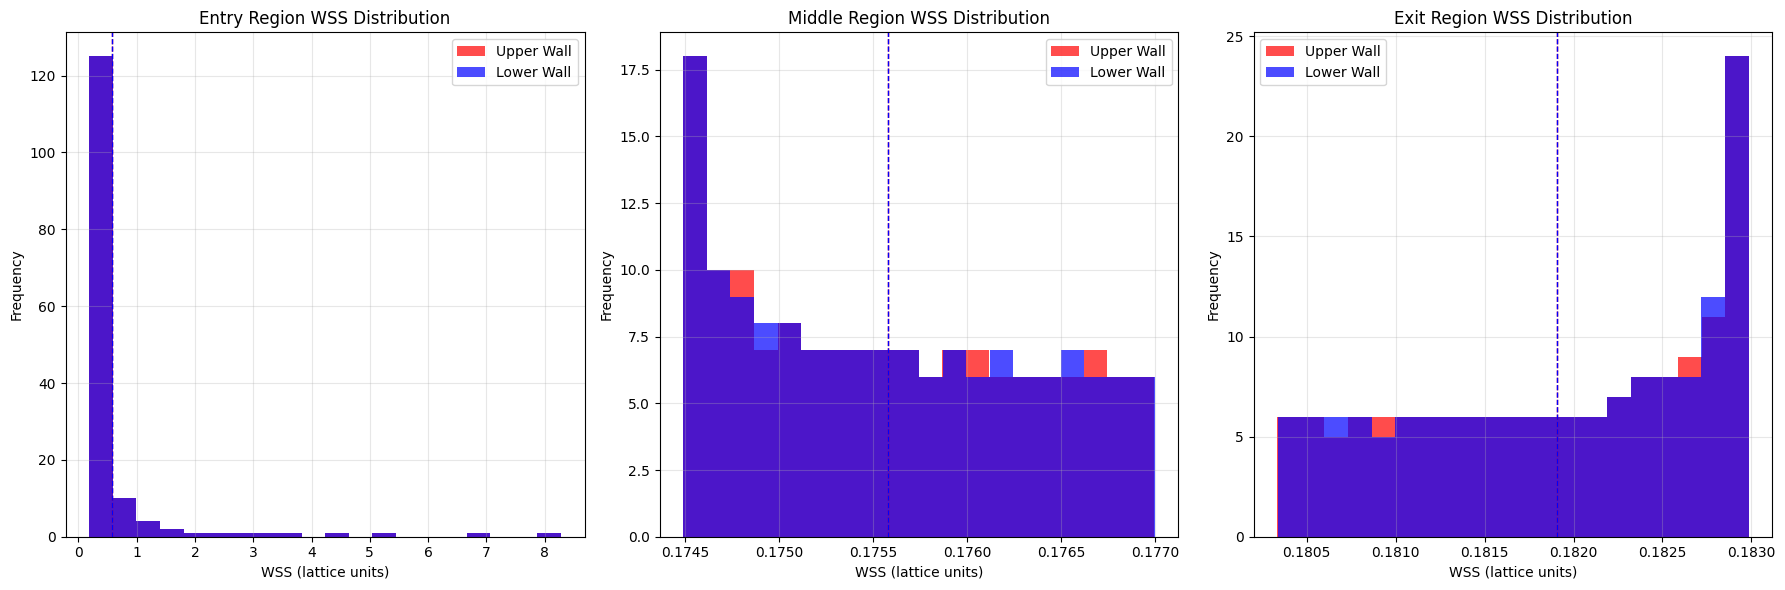


Analyzing wall shear stress distribution for maximum velocity frame 20000...


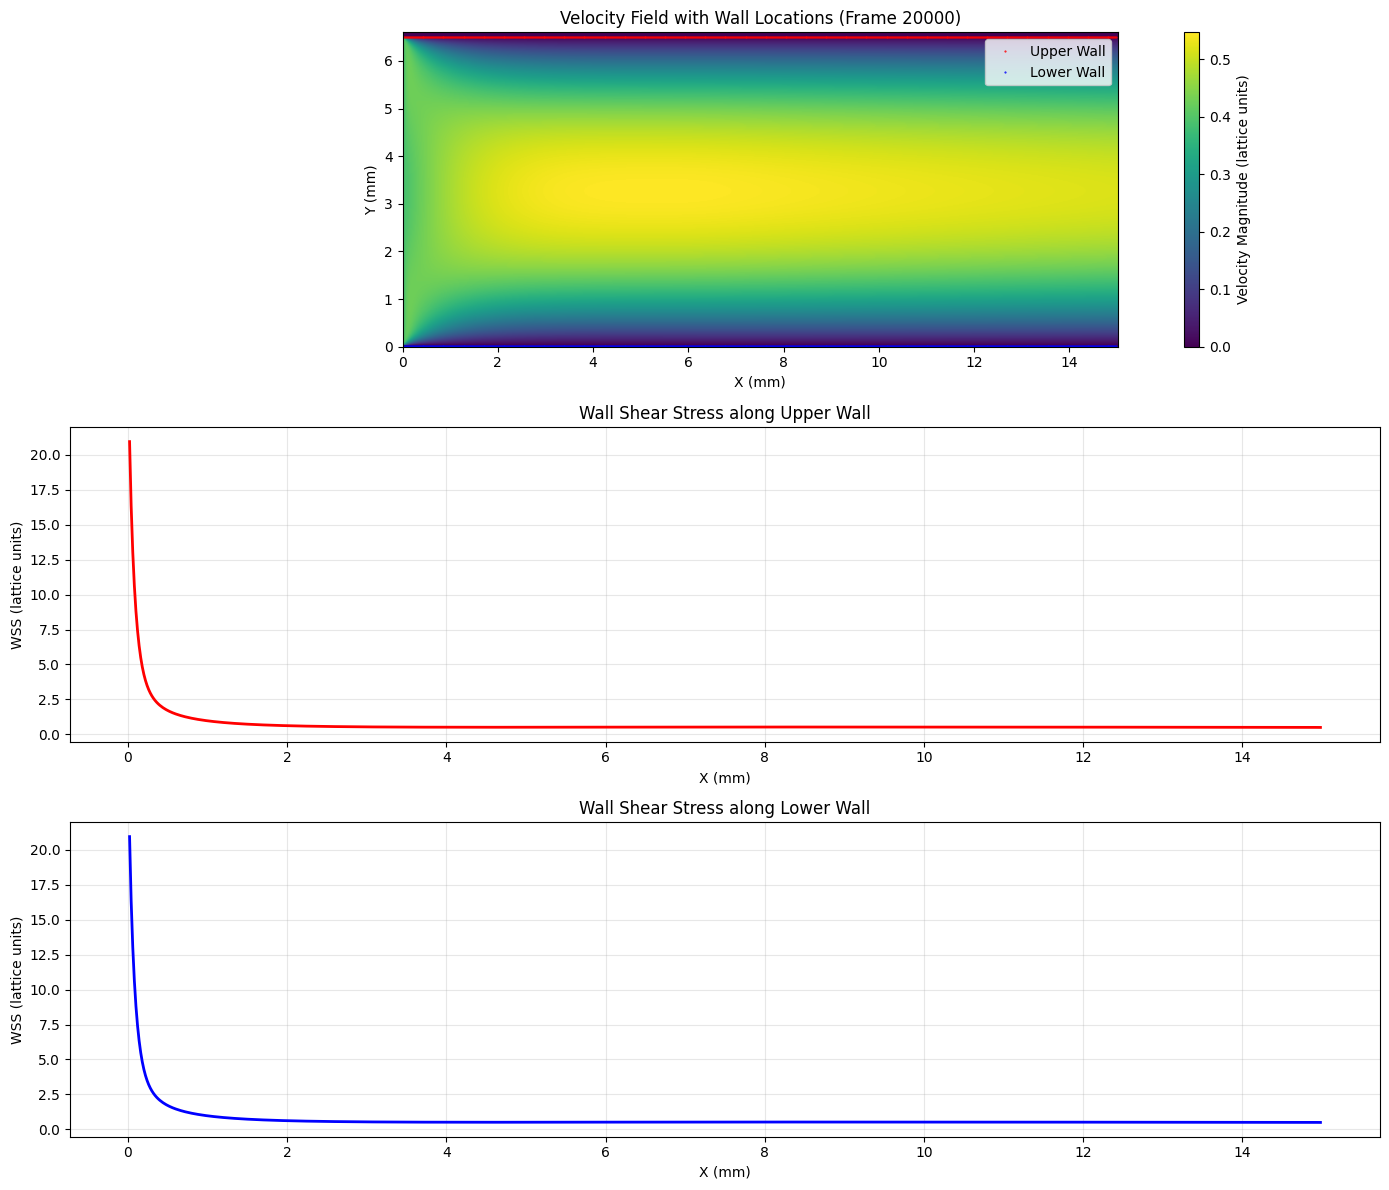


Wall Shear Stress Statistics:
Upper Wall - Mean: 0.726855, Max: 20.928190, Std: 1.255990
Lower Wall - Mean: 0.726856, Max: 20.928197, Std: 1.255991
Overall - Mean: 0.726855, Max: 20.928197

Entry Region:
  Upper Wall - Mean: 1.549297, Max: 20.928190
  Lower Wall - Mean: 1.549297, Max: 20.928197

Middle Region:
  Upper Wall - Mean: 0.527185, Max: 0.529506
  Lower Wall - Mean: 0.527186, Max: 0.529506

Exit Region:
  Upper Wall - Mean: 0.513573, Max: 0.519552
  Lower Wall - Mean: 0.513573, Max: 0.519547


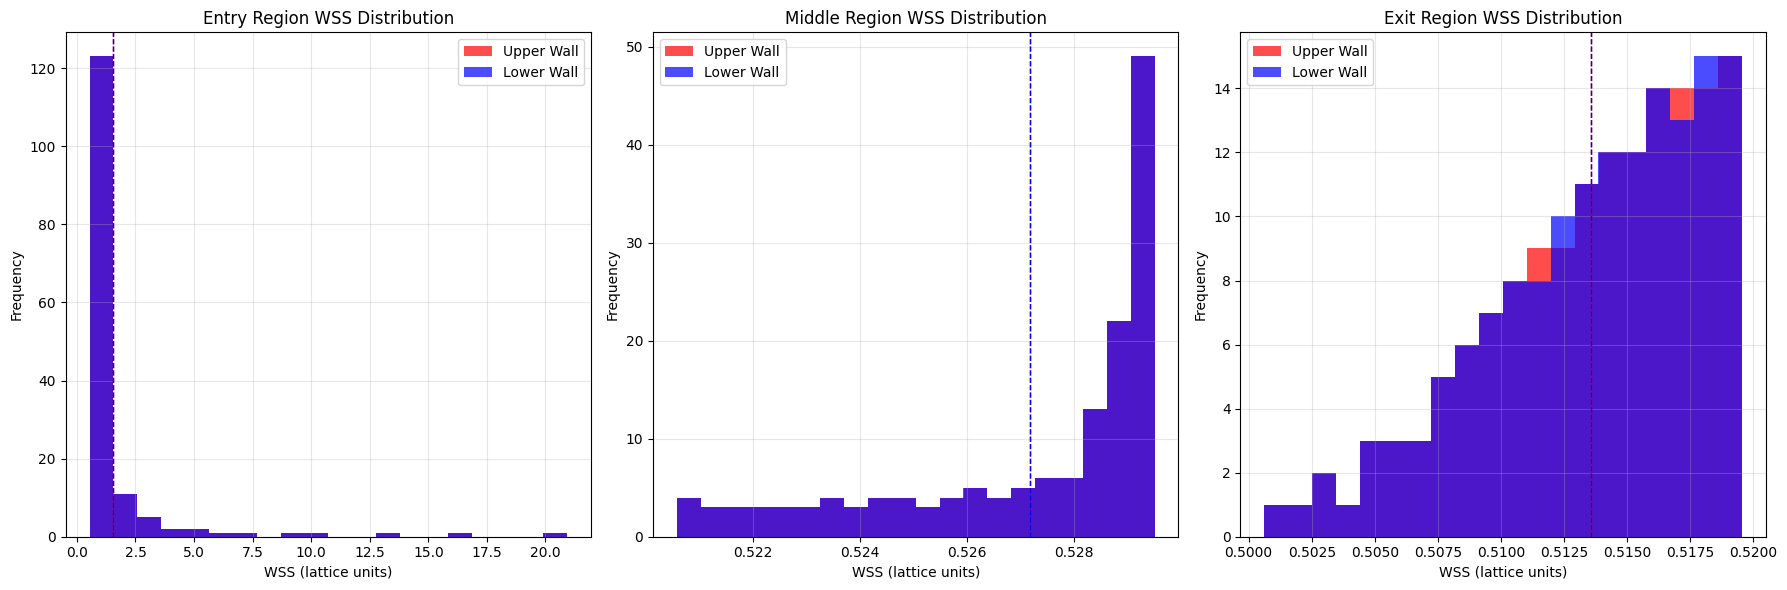

In [63]:
def analyze_pipe_wss(velocity_data, wss_data, frame_idx=50):
    """Analyze wall shear stress distribution along the pipe walls"""
    if velocity_data is None or wss_data is None:
        print("Missing velocity or WSS data")
        return
    
    # Extract frame data
    frame_numbers = velocity_data.get('frame_numbers')
    u_magnitude = velocity_data.get('u_magnitude')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if frame_numbers is None or u_magnitude is None or wss_magnitude is None:
        print("Missing required data components")
        return
    
    # Ensure frame_idx is valid
    if frame_idx >= len(u_magnitude):
        frame_idx = len(u_magnitude) // 2
        print(f"Frame index out of range. Using frame {frame_idx} instead.")
    
    # Get data for the specified frame
    frame_num = frame_numbers[frame_idx]
    frame_u_mag = u_magnitude[frame_idx]
    frame_wss_mag = wss_magnitude[frame_idx]
    
    # Get dimensions
    ny, nx = frame_u_mag.shape
    
    # Get physical units
    dx = pipe_tdzh_nnbgk_key_params.get('dx', 2e-5)
    dt = pipe_tdzh_nnbgk_key_params.get('dt', 1e-5)
    
    # Get vessel parameters
    if pipe_tdzh_nnbgk_parameters is not None:
        vessel_centre_lu = pipe_tdzh_nnbgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2)
    else:
        vessel_centre_lu = ny // 2
    
    # Find the upper and lower walls by detecting non-zero WSS values
    upper_wall_indices = []
    lower_wall_indices = []
    
    for x in range(nx):
        # Find wall cells in this column (non-zero WSS)
        wall_indices = np.where(frame_wss_mag[:, x] > 0)[0]
        
        if len(wall_indices) > 0:
            # Separate upper and lower walls based on vessel center
            upper_indices = wall_indices[wall_indices > vessel_centre_lu]
            lower_indices = wall_indices[wall_indices < vessel_centre_lu]
            
            # Take the innermost wall cells (closest to the lumen)
            if len(upper_indices) > 0:
                upper_wall_indices.append((x, upper_indices.min()))
            if len(lower_indices) > 0:
                lower_wall_indices.append((x, lower_indices.max()))
    
    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # 1. Plot velocity field with wall locations marked
    im1 = ax1.imshow(frame_u_mag, cmap='viridis', origin='lower',
                   extent=[0, nx*dx*1000, 0, ny*dx*1000])
    
    # Mark the detected wall positions
    if upper_wall_indices:
        upper_x = [x[0] for x in upper_wall_indices]
        upper_y = [x[1] for x in upper_wall_indices]
        ax1.plot(np.array(upper_x)*dx*1000, np.array(upper_y)*dx*1000, 'r.', markersize=1, label='Upper Wall')
    
    if lower_wall_indices:
        lower_x = [x[0] for x in lower_wall_indices]
        lower_y = [x[1] for x in lower_wall_indices]
        ax1.plot(np.array(lower_x)*dx*1000, np.array(lower_y)*dx*1000, 'b.', markersize=1, label='Lower Wall')
    
    ax1.set_title(f'Velocity Field with Wall Locations (Frame {frame_num})')
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.legend()
    fig.colorbar(im1, ax=ax1, label='Velocity Magnitude (lattice units)')
    
    # 2. Plot WSS along the upper wall
    if upper_wall_indices:
        upper_x_mm = np.array([x[0] for x in upper_wall_indices]) * dx * 1000
        upper_wss = np.array([frame_wss_mag[y, x] for x, y in upper_wall_indices])
        
        ax2.plot(upper_x_mm, upper_wss, 'r-', linewidth=2)
        ax2.set_title('Wall Shear Stress along Upper Wall')
        ax2.set_xlabel('X (mm)')
        ax2.set_ylabel('WSS (lattice units)')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No upper wall data available', 
                horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    # 3. Plot WSS along the lower wall
    if lower_wall_indices:
        lower_x_mm = np.array([x[0] for x in lower_wall_indices]) * dx * 1000
        lower_wss = np.array([frame_wss_mag[y, x] for x, y in lower_wall_indices])
        
        ax3.plot(lower_x_mm, lower_wss, 'b-', linewidth=2)
        ax3.set_title('Wall Shear Stress along Lower Wall')
        ax3.set_xlabel('X (mm)')
        ax3.set_ylabel('WSS (lattice units)')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No lower wall data available', 
                horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate WSS statistics
    if upper_wall_indices and lower_wall_indices:
        upper_wss = np.array([frame_wss_mag[y, x] for x, y in upper_wall_indices])
        lower_wss = np.array([frame_wss_mag[y, x] for x, y in lower_wall_indices])
        
        print("\nWall Shear Stress Statistics:")
        print(f"Upper Wall - Mean: {upper_wss.mean():.6f}, Max: {upper_wss.max():.6f}, Std: {upper_wss.std():.6f}")
        print(f"Lower Wall - Mean: {lower_wss.mean():.6f}, Max: {lower_wss.max():.6f}, Std: {lower_wss.std():.6f}")
        print(f"Overall - Mean: {np.concatenate([upper_wss, lower_wss]).mean():.6f}, "
              f"Max: {max(upper_wss.max(), lower_wss.max()):.6f}")
        
        # Also create a comparison plot for entry, middle, and exit regions
        entry_region = int(nx * 0.2)    # First 20% of the pipe
        middle_region = int(nx * 0.5)   # Middle of the pipe
        exit_region = int(nx * 0.8)     # Last 20% of the pipe
        
        regions = {
            'Entry': (0, entry_region),
            'Middle': (middle_region - int(nx * 0.1), middle_region + int(nx * 0.1)),
            'Exit': (exit_region, nx-1)
        }
        
        # Create region comparison plot
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        for i, (region_name, (start_x, end_x)) in enumerate(regions.items()):
            # Filter upper and lower wall indices for this region
            region_upper = [(x, y) for x, y in upper_wall_indices if start_x <= x <= end_x]
            region_lower = [(x, y) for x, y in lower_wall_indices if start_x <= x <= end_x]
            
            if region_upper and region_lower:
                region_upper_wss = np.array([frame_wss_mag[y, x] for x, y in region_upper])
                region_lower_wss = np.array([frame_wss_mag[y, x] for x, y in region_lower])
                
                # Plot WSS distribution as a histogram
                axs[i].hist(region_upper_wss, bins=20, alpha=0.7, label='Upper Wall', color='red')
                axs[i].hist(region_lower_wss, bins=20, alpha=0.7, label='Lower Wall', color='blue')
                axs[i].set_title(f'{region_name} Region WSS Distribution')
                axs[i].set_xlabel('WSS (lattice units)')
                axs[i].set_ylabel('Frequency')
                axs[i].legend()
                axs[i].grid(True, alpha=0.3)
                
                # Add mean lines
                axs[i].axvline(region_upper_wss.mean(), color='red', linestyle='--', linewidth=1)
                axs[i].axvline(region_lower_wss.mean(), color='blue', linestyle='--', linewidth=1)
                
                # Print statistics for this region
                print(f"\n{region_name} Region:")
                print(f"  Upper Wall - Mean: {region_upper_wss.mean():.6f}, Max: {region_upper_wss.max():.6f}")
                print(f"  Lower Wall - Mean: {region_lower_wss.mean():.6f}, Max: {region_lower_wss.max():.6f}")
            else:
                axs[i].text(0.5, 0.5, f'No {region_name.lower()} region data', 
                          horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
        
        plt.tight_layout()
        plt.show()
        
        return upper_wall_indices, lower_wall_indices, upper_wss, lower_wss
    
    return None, None, None, None

# Analyze WSS distribution for the middle frame of the simulation
try:
    middle_frame = len(pipe_tdzh_nnbgk_velocity['frame_numbers']) // 2
    print(f"\nAnalyzing wall shear stress distribution for middle frame {pipe_tdzh_nnbgk_velocity['frame_numbers'][middle_frame]}...")
    upper_wall, lower_wall, upper_wss, lower_wss = analyze_pipe_wss(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss, 
                                                                   frame_idx=middle_frame)
    
    # Also analyze the frame with maximum velocity
    max_velocities = np.array([frame.max() for frame in pipe_tdzh_nnbgk_velocity['u_magnitude']])
    max_velocity_frame = np.argmax(max_velocities)
    if max_velocity_frame != middle_frame:  # Only do this if it's different from the middle frame
        print(f"\nAnalyzing wall shear stress distribution for maximum velocity frame {pipe_tdzh_nnbgk_velocity['frame_numbers'][max_velocity_frame]}...")
        analyze_pipe_wss(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss, frame_idx=max_velocity_frame)
except Exception as e:
    print(f"Error analyzing pipe wall shear stress: {e}")
    import traceback
    traceback.print_exc()